# ARIMA time-series modelling using Zipline
## 1. Dependencies

In [169]:
%load_ext zipline
%matplotlib notebook
#%matplotlib inline
import itertools
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from zipline.api import symbol

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


## 2. Preprocess time-series data
### 2.1 extract historical data from zipline backtester

In [225]:
ts = None

def before_trading_start(context, data):
    # extract historical data from zipline backtester to use outside of backtester
    global ts
    ticker = 'AAPL'
    ts = pd.DataFrame(data.history(symbol(ticker), 'price', 3000, '1d'))
    ts = ts.rename(index=str, columns={symbol(ticker): ticker})
    ts.index = pd.to_datetime(ts.index)
    
    print('ts head:')
    print(ts.head())
    print('ts tail:')
    print(ts.tail())
    
%zipline --bundle quantopian-quandl --start 2018-1-1 --end 2018-1-2 -o backtest.pickle

ts head:
             AAPL
2006-02-02  9.266
2006-02-03  9.234
2006-02-06  8.650
2006-02-07  8.688
2006-02-08  8.844
ts tail:
              AAPL
2017-12-26  170.57
2017-12-27  170.60
2017-12-28  171.08
2017-12-29  169.23
2018-01-02  172.26


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-01-02 21:00:00+00:00,None,0.0,None,0.007157,None,None,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0


### 2.2 Calculate log-return
ARIMA will use log-returns instead of the actual time-series as input

In [226]:
# log scale
ts['log'] = np.log(ts)

# log return
ts['logret'] = ts['log'].pct_change()
ts = ts[1:]

print('ts head:')
print(ts.head())
print('ts tail:')
print(ts.tail())

ts head:
             AAPL       log    logret
2006-02-03  9.234  2.222892 -0.001554
2006-02-06  8.650  2.157559 -0.029391
2006-02-07  8.688  2.161943  0.002032
2006-02-08  8.844  2.179739  0.008232
2006-02-09  8.348  2.122022 -0.026479
ts tail:
              AAPL       log    logret
2017-12-26  170.57  5.139146 -0.004975
2017-12-27  170.60  5.139322  0.000034
2017-12-28  171.08  5.142131  0.000547
2017-12-29  169.23  5.131259 -0.002114
2018-01-02  172.26  5.149005  0.003458


## 3. Visualization of data

<IPython.core.display.Javascript object>


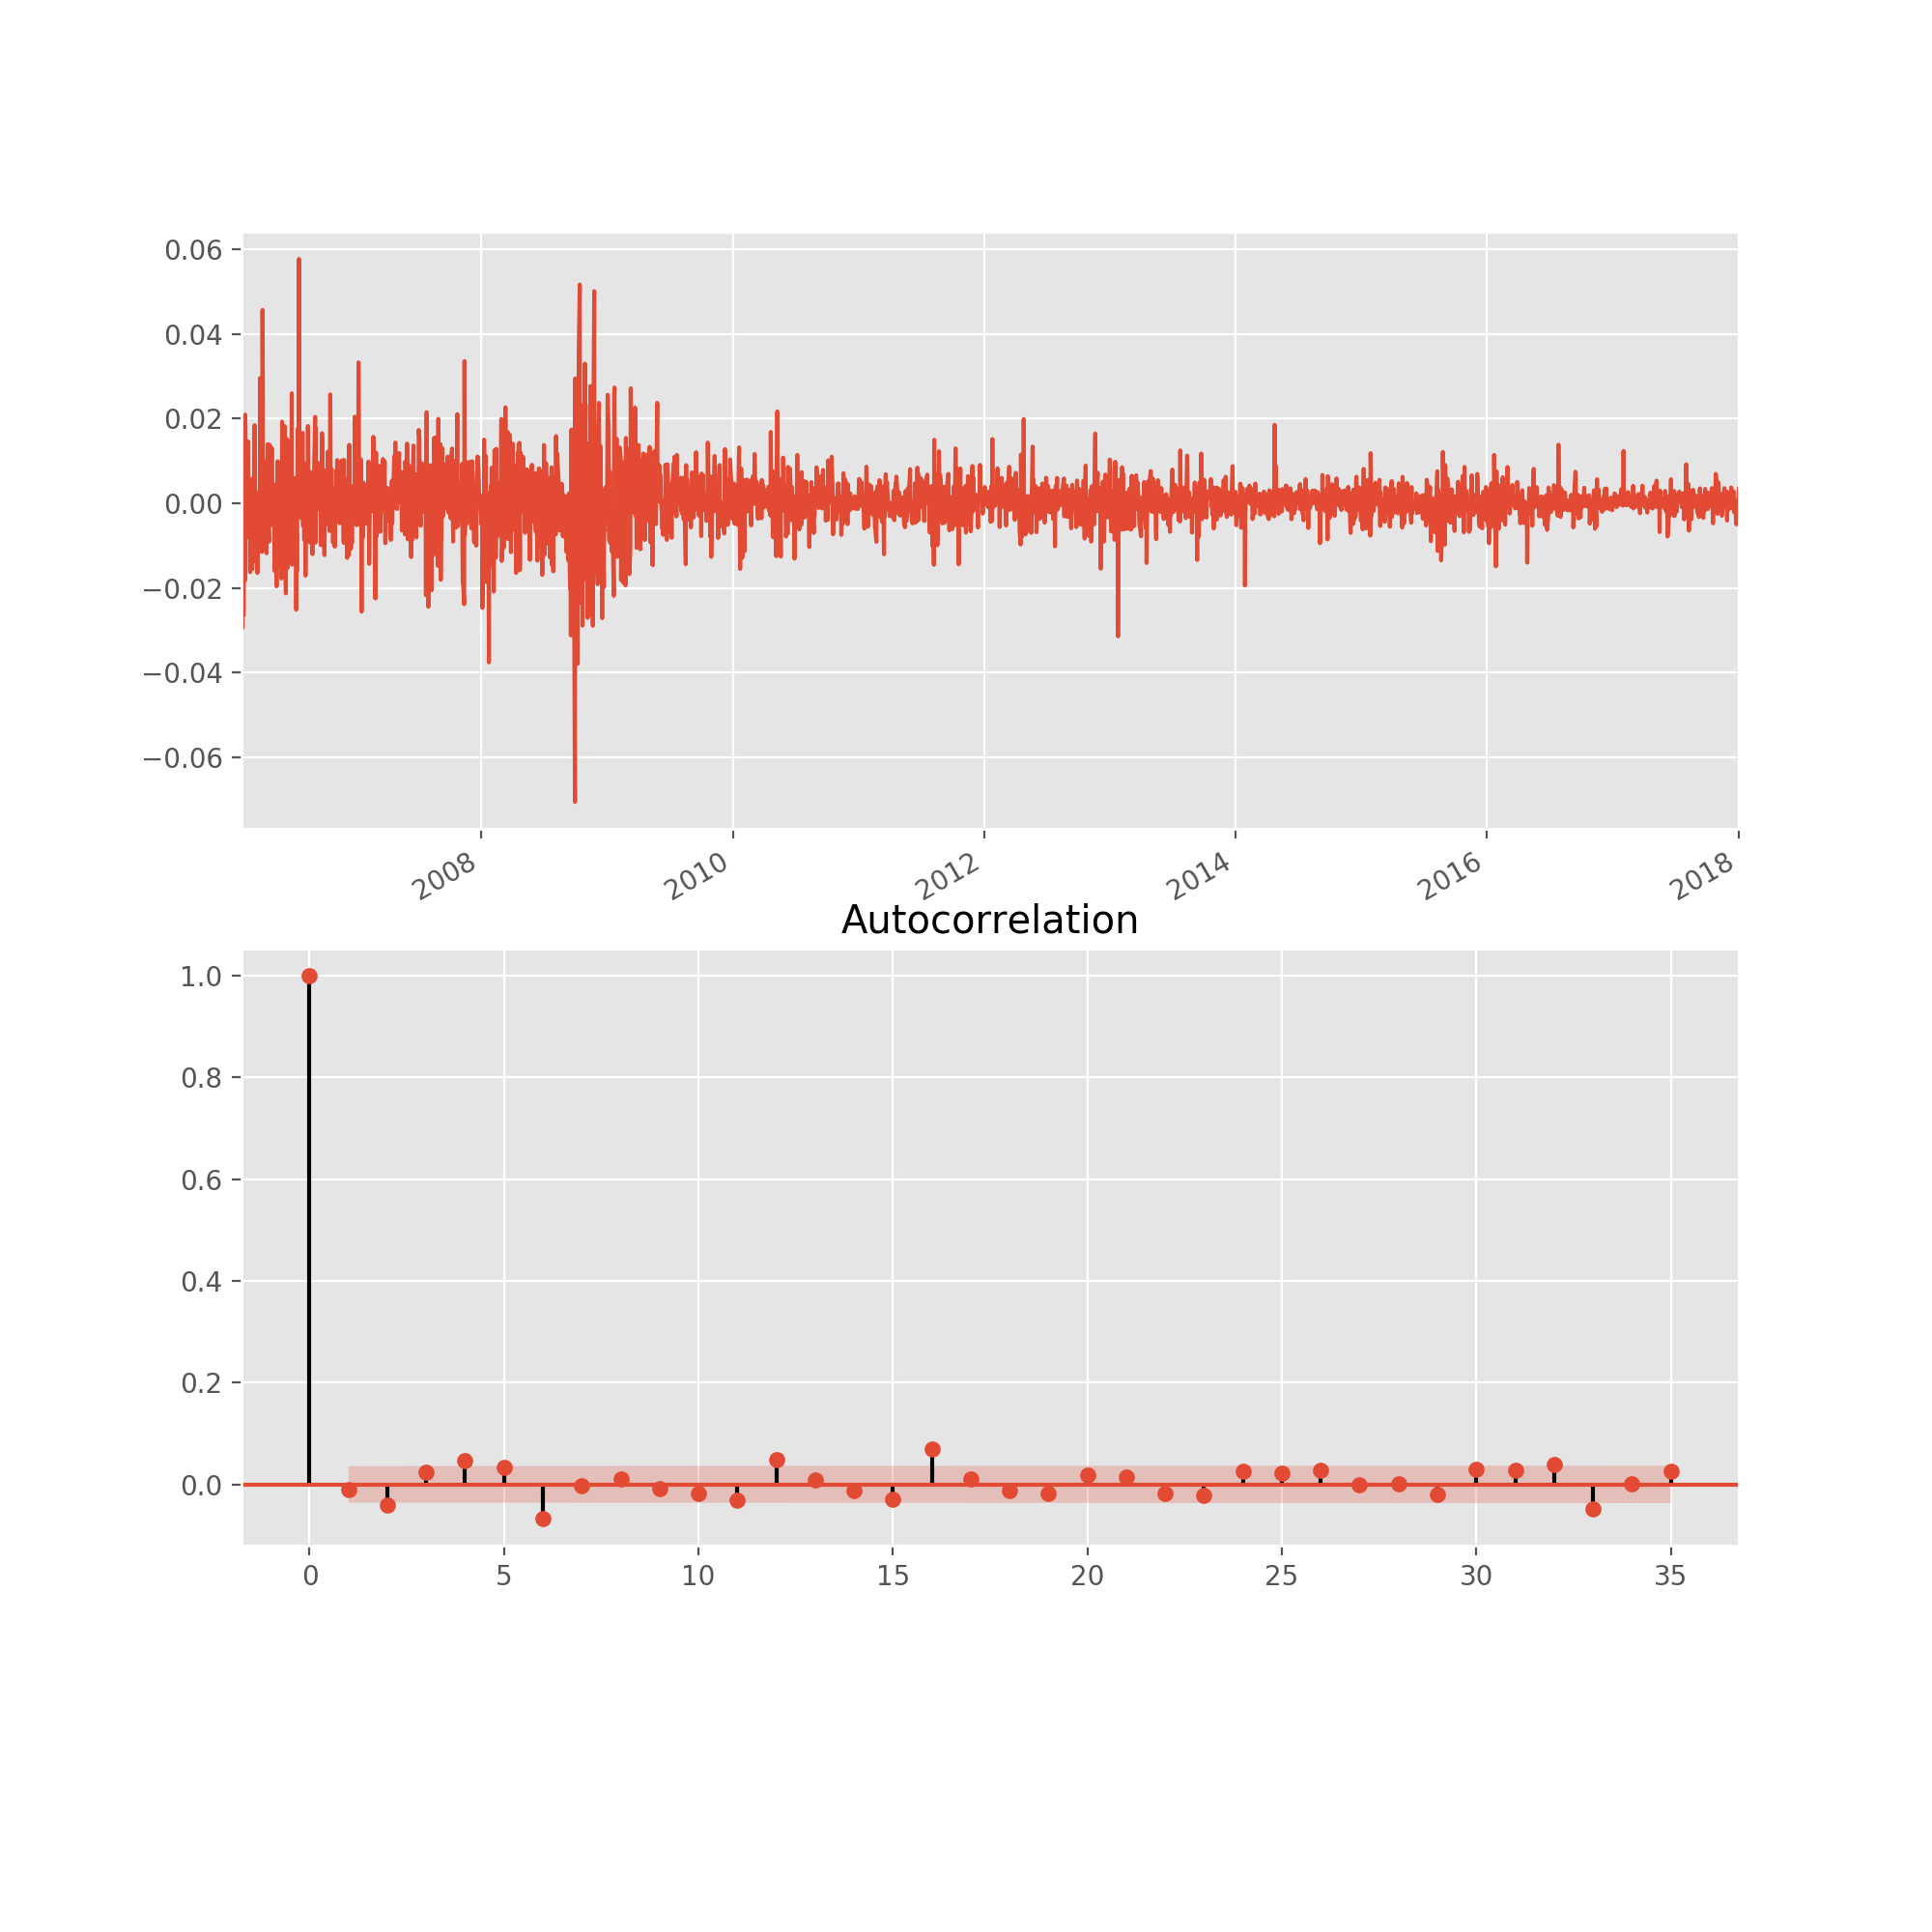

In [227]:
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

# plot log return
ts['logret'].plot(ax=ax1)

# plot autocorrelation
sm.graphics.tsa.plot_acf(ts['logret'],lags=35,ax=ax2)
fig.show()

In [228]:
ps, ds, qs = range(1,6), range(2), range(1,6)
best_params, best_model = None, None
for p, d, q in itertools.product(ps, ds, qs):
    try:
        model_arima = sm.tsa.ARIMA(ts['logret'], (p,d,q)).fit(method='mle')
        print(p,d,q,model_arima.aic)
        if not best_model or model_arima.aic < best_model.aic:
            best_params = (p,d,q)
            best_model = model_arima
            print('new best')
    except:
        print(p,d,q,'could not fit')

1 0 1 could not fit
1 0 2 could not fit
1 0 3 could not fit
1 0 4 could not fit
1 0 5 could not fit
1 1 1 -21344.739284211042
new best


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 1 2 -21355.41239074428
new best
1 1 3 -21375.076444055285
new best


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1 4 -21367.95304954342


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1 5 -21344.445921310442
2 0 1 -21402.32287575126
new best
2 0 2 could not fit
2 0 3 could not fit
2 0 4 could not fit
2 0 5 could not fit


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 1 -21363.521596823368


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 2 -21358.60546190832
2 1 3 -21315.12457457922


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 4 -21329.591196412366


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 5 -21312.97186449913
3 0 1 -21404.83040093237
new best
3 0 2 could not fit
3 0 3 could not fit
3 0 4 could not fit
3 0 5 could not fit


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 1 -21363.34842281364
3 1 2 -21370.220010118795


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 3 -21309.341965923923


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 4 -21344.520430167904


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 5 -21373.03230370104
4 0 1 -21407.015650227924
new best


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 0 2 -21411.03112756133
new best


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 0 3 -21406.331620951834
4 0 4 could not fit
4 0 5 could not fit


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 1 -21378.399409263384


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 2 -21330.41444599416


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 3 -21335.872849347124


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 4 -21372.11600232689


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 5 -21370.942737204667


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 0 1 -21413.954635077727
new best


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 0 2 -21415.046424753044
new best


/anaconda/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


5 0 3 could not fit


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 0 4 -21412.672276388425
5 0 5 could not fit


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 1 -21314.59046543158


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 2 -21374.00615712205


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 3 -21350.928033041575


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 4 -21343.087426664668
5 1 5 -21353.842769394952


/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## 5. Analyze results
Model is a good fit if all p values are above 0.05!  

best model params:  (5, 0, 2)
p values:  ['0.9487', '0.9964', '0.9996', '0.9957', '0.9933', '0.9414', '0.9722', '0.962', '0.9775', '0.9879', '0.9003', '0.5318', '0.6047', '0.6772', '0.5801', '0.05004', '0.06807', '0.09075', '0.1012', '0.1158']
number of p values below 0.05:  0
                              ARMA Model Results                              
Dep. Variable:                 logret   No. Observations:                 2999
Model:                     ARMA(5, 2)   Log Likelihood               10716.523
Method:                           mle   S.D. of innovations              0.007
Date:                Thu, 20 Sep 2018   AIC                         -21415.046
Time:                        23:31:18   BIC                         -21360.992
Sample:                    02-03-2006   HQIC                        -21395.603
                         - 01-02-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
---------

/anaconda/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


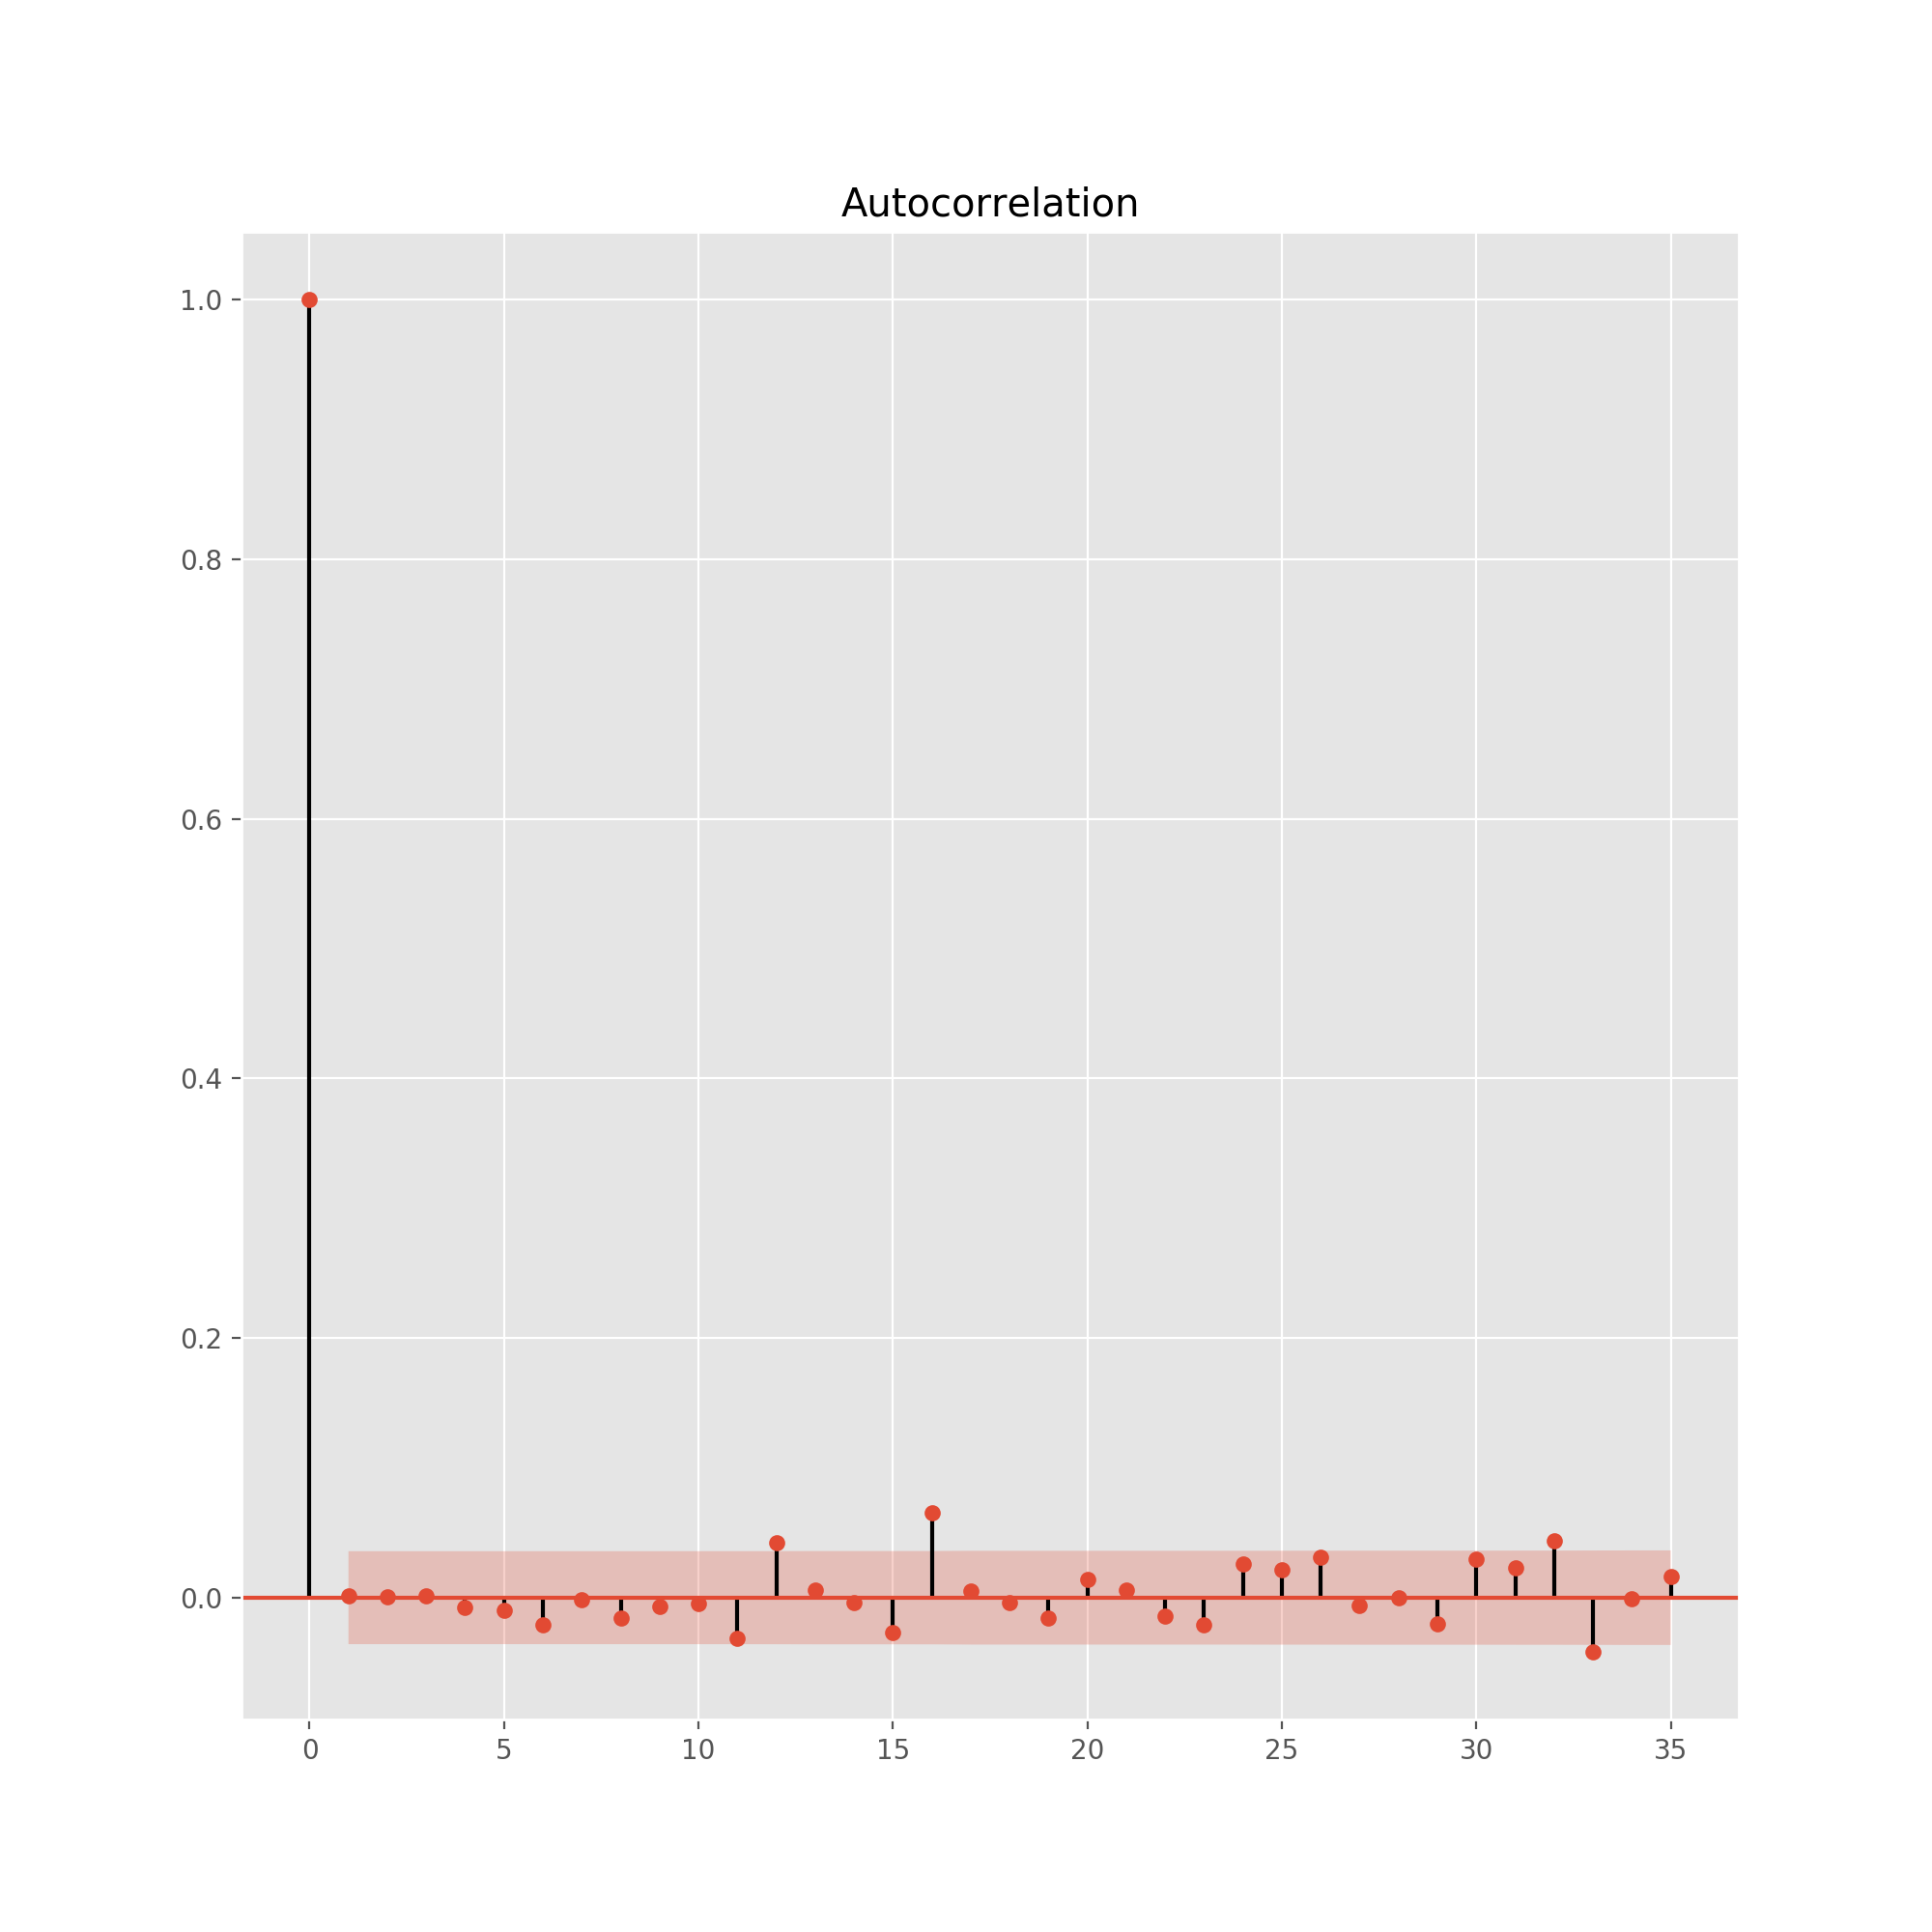

In [229]:
print('best model params: ',best_params)
_, p_values = sm.stats.diagnostic.acorr_ljungbox(best_model.resid, lags=20, boxpierce=False)
print('p values: ', list(map(lambda x: "{:.4}".format(x),p_values)))
print('number of p values below 0.05: ', len([p for p in p_values if p < 0.05]))
print(best_model.summary())

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)

sm.graphics.tsa.plot_acf(best_model.resid,lags=35,ax=ax)
fig.show()

2006-02-03    9.234000
2006-02-06    0.000322
2006-02-07    0.000715
2006-02-08    0.001434
2006-02-09   -0.000666
2006-02-10   -0.001264
2006-02-13    0.000125
2006-02-14    0.000858
2006-02-15    0.000044
2006-02-16   -0.002138
2006-02-17    0.001383
2006-02-21    0.000059
2006-02-22    0.002332
2006-02-23    0.000894
2006-02-24   -0.000822
2006-02-27    0.000005
2006-02-28    0.001057
2006-03-01    0.001635
2006-03-02    0.000158
2006-03-03   -0.000743
2006-03-06   -0.000207
2006-03-07    0.000566
2006-03-08    0.001339
2006-03-09   -0.000895
2006-03-10   -0.000943
2006-03-13    0.000911
2006-03-14    0.000643
2006-03-15   -0.002000
2006-03-16   -0.000386
2006-03-17    0.002455
                ...   
2017-11-17    0.000122
2017-11-20    0.000026
2017-11-21    0.000171
2017-11-22    0.000311
2017-11-24    0.000274
2017-11-27    0.000131
2017-11-28    0.000546
2017-11-29    0.000668
2017-11-30    0.000280
2017-12-01    0.000235
2017-12-04    0.000060
2017-12-05    0.000191
2017-12-06 

<IPython.core.display.Javascript object>


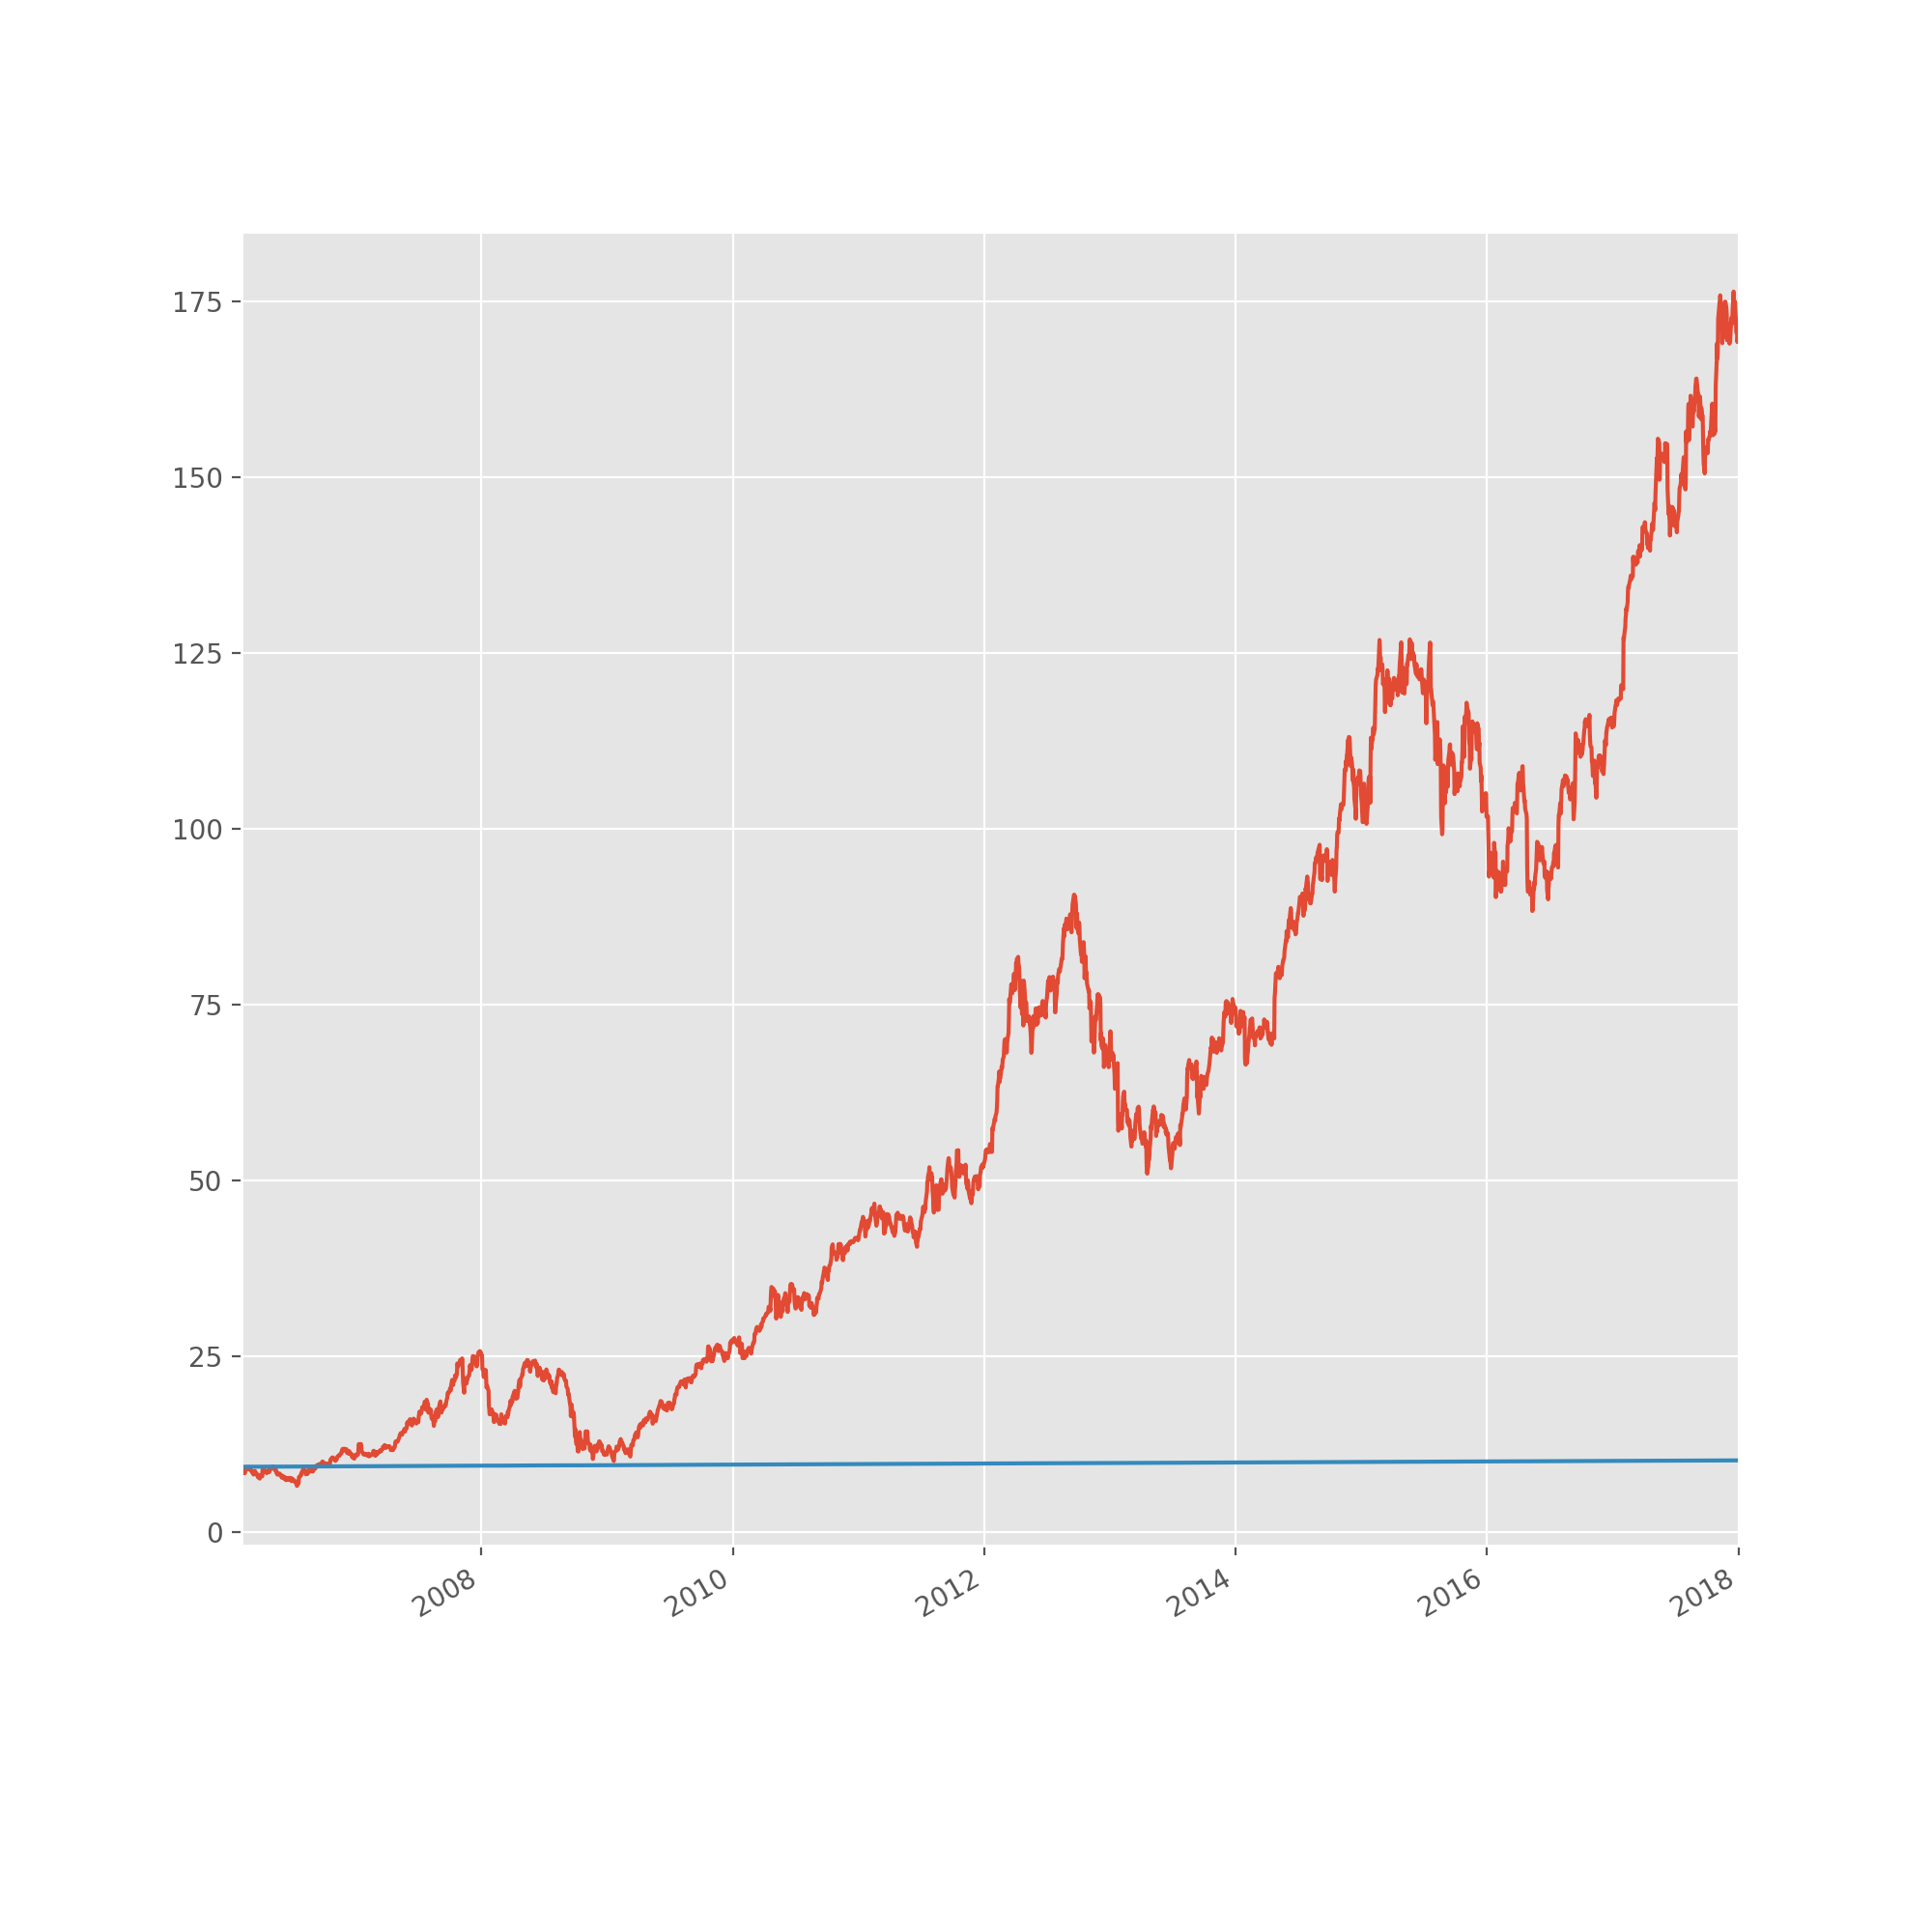

In [234]:
preds = best_model.predict()
preds[0] = ts['AAPL'][0]
# todo start here plot predicted ts
print(preds)
preds = preds.cumsum()

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ts['AAPL'].plot()
preds.plot()